<a href="https://colab.research.google.com/github/NguyenDong143/Python-for-Finance-Investment-Fundamentals-Data-Analytics/blob/master/Predict_data_70_20_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from google.colab import files
import io

# Thiết lập thẩm mỹ cho biểu đồ
plt.style.use('ggplot')
%matplotlib inline

In [20]:
# Đọc dữ liệu
df = pd.read_csv('/content/fgi_historical.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Lọc bỏ các cột không phải dạng số (như 'state') và chỉ giữ lại 'fgi' và 'close'
df_numeric = df[['close', 'fgi']]
print(f"Dữ liệu có {df_numeric.shape[0]} dòng và {df_numeric.shape[1]} cột đặc trưng số.")
df_numeric.head(3)

Dữ liệu có 1499 dòng và 2 cột đặc trưng số.


,close,fgi
0,966.67,60.54
1,965.14,47.54
2,955.79,49.08


In [21]:
def create_sliding_window(data, window_size=10):
    X, y = [], []
    # Chúng ta dự báo cột 'close' (VN-Index)
    # Target là giá của ngày tiếp theo (index + window_size)
    close_idx = data.columns.get_loc('close')

    data_values = data.values
    for i in range(len(data_values) - window_size):
        # Lấy toàn bộ các đặc trưng trong cửa sổ (window_size ngày)
        window = data_values[i : i + window_size]
        X.append(window.flatten()) # Phẳng hóa để đưa vào mạng ANN (Dense layers)
        y.append(data_values[i + window_size, close_idx])

    return np.array(X), np.array(y)

# Cấu hình: Nhìn lại 10 ngày để dự báo ngày thứ 11
WINDOW_SIZE = 10
X_raw, y_raw = create_sliding_window(df_numeric, window_size=WINDOW_SIZE)

print(f"Kích thước tập X: {X_raw.shape}")
print(f"Kích thước tập y: {y_raw.shape}")

Kích thước tập X: (1489, 20)
Kích thước tập y: (1489,)


In [22]:
# Chia Train/Test (80/20) theo trình tự thời gian
split = int(len(X_raw) * 0.8)
X_train_unscaled, X_test_unscaled = X_raw[:split], X_raw[split:]
y_train_unscaled, y_test_unscaled = y_raw[:split], y_raw[split:]

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_unscaled)
X_test = scaler_X.transform(X_test_unscaled)

y_train = scaler_y.fit_transform(y_train_unscaled.reshape(-1, 1))
y_test = scaler_y.transform(y_test_unscaled.reshape(-1, 1))

In [24]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Sử dụng Adam optimizer và Huber loss (chống nhiễu tốt cho dữ liệu chứng khoán)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='huber')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,641 (190.00 KB)

 Trainable params: 48,641 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
print("Bắt đầu huấn luyện...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Bắt đầu huấn luyện...
Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0865 - val_loss: 0.0011
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0094
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0068
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0119
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0111
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0088
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 0.0113


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

--- KẾT QUẢ ĐÁNH GIÁ ---
RMSE: 86.37 điểm
MAE: 72.65 điểm
R2 Score: 0.7954


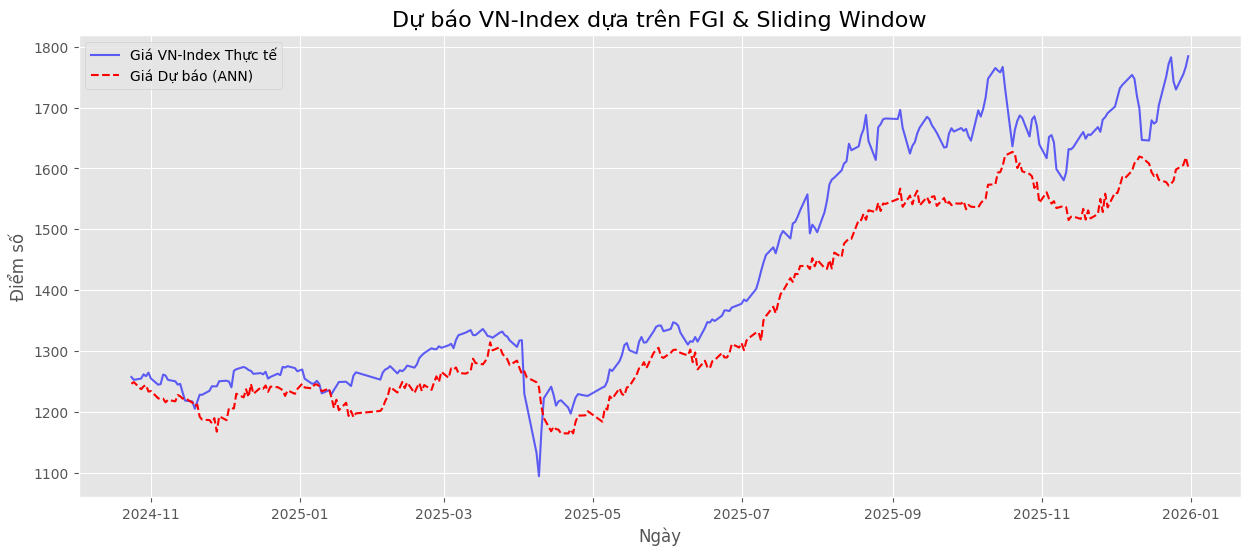

In [26]:
# Dự báo
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = y_test_unscaled

# Tính toán các chỉ số
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"\n--- KẾT QUẢ ĐÁNH GIÁ ---")
print(f"RMSE: {rmse:.2f} điểm")
print(f"MAE: {mae:.2f} điểm")
print(f"R2 Score: {r2:.4f}")

# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 6))
dates = df['date'].iloc[split + WINDOW_SIZE:].values
plt.plot(dates, y_actual, label='Giá VN-Index Thực tế', color='blue', alpha=0.6)
plt.plot(dates, y_pred, label='Giá Dự báo (ANN)', color='red', linestyle='--')
plt.title("Dự báo VN-Index dựa trên FGI & Sliding Window", fontsize=16)
plt.xlabel("Ngày")
plt.ylabel("Điểm số")
plt.legend()
plt.show()